# LPD Tile Testing

This is a notebook used to analyse/test single tiles. It does this by taking mean and standard deviation data of the input data and comparing this to preset thresholds (taken from good, working tiles). The same colourmap is used from the LPD GUI so tiles should look similar to how they do in the live view element of the GUI.

### Instructions to use:
1. Take data using LPD GUI
2. Open this notebook and select the file you wish to analyse from the list of files
3. Select which side and MINI connector the tile was connected to during the run you selected
4. Enable plots of trigger images and first full image if needed
5. Press 'Analyse Data' button

### Results of Analysis:
The results start with a table breaking down the results of the bad components of the tile, and giving details about which data has been used to come to that conclusion. Then there's a plot of the tile taking a mean value of each pixel, using each train in the file, resulting in a mean tile over the course of that run. A histogram follows this to show any variation in the data. The same thing is done again but by using the standard deviation of the data. The final mandatory plot shows a tile containing all the faults picked up by the analysis. You can also choose to see the first image from the first four triggers and the first full image in the file. Once these options have been enabled, they won't disappear until the cell has been re-run.

In [3]:
%reload_ext autoreload
%matplotlib notebook

import numpy as np
import ipywidgets as widgets
from IPython.display import HTML
import matplotlib.pyplot as plt
from os import listdir, path
from os.path import isfile, join, getmtime
from datetime import timedelta, date, datetime
import warnings
import matplotlib.cbook
from scipy import optimize
from scipy import stats

# Ignore 'Adding an axes using the same arguments as a previous axes'
warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)

import extract_data
import test_results
import fault_tiles
import test_data
import plot
import generate_report

<IPython.core.display.Javascript object>


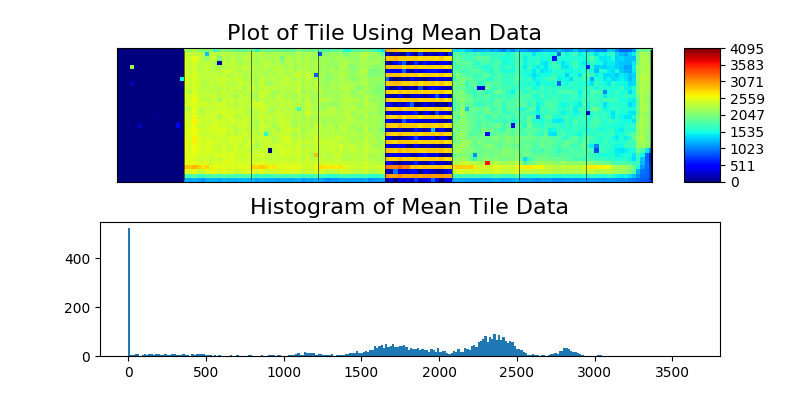

<IPython.core.display.Javascript object>


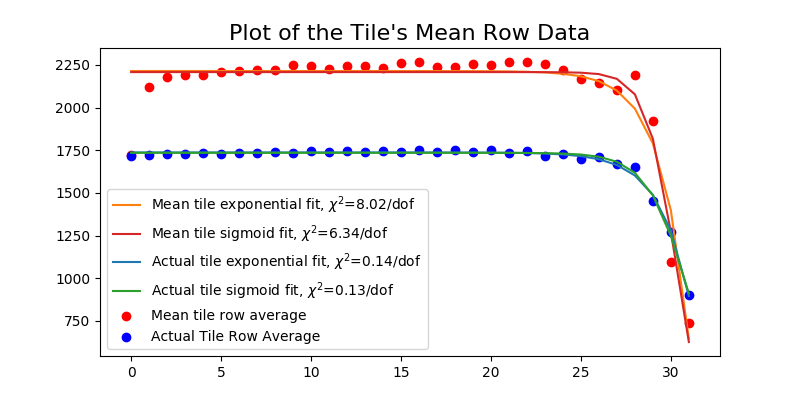

<IPython.core.display.Javascript object>


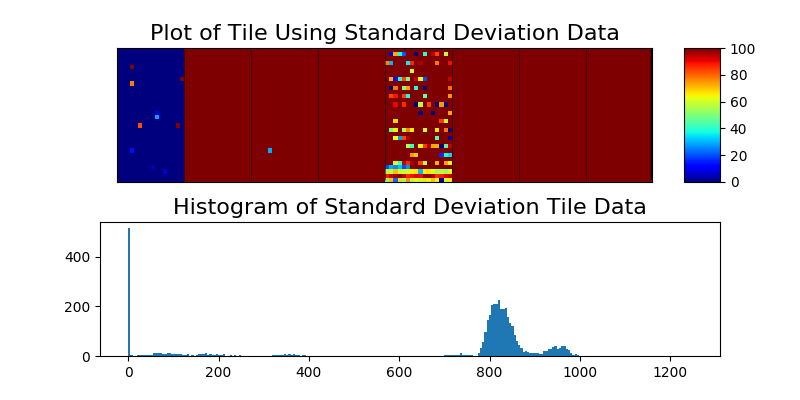

<IPython.core.display.Javascript object>


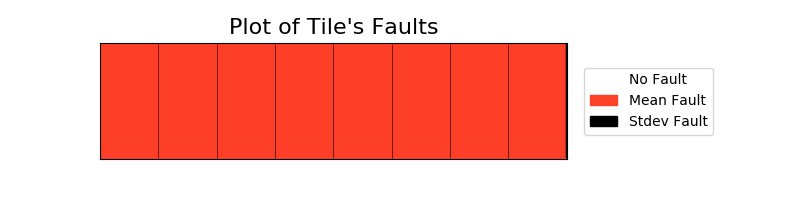

<IPython.core.display.Javascript object>


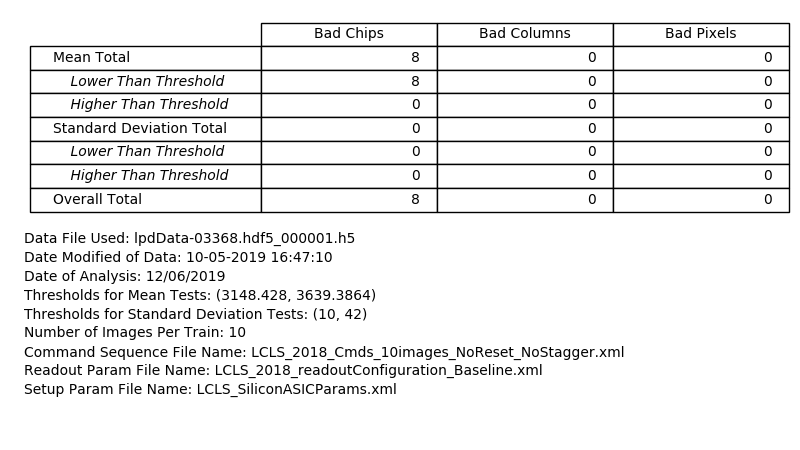

In [4]:
%autoreload 2


class DataAnalyser():

    def __init__(self):
        # Disable interactive mode and only use fig.show() to have a finer control over when plots are displayed
        plt.ioff()

        # Init variables - widgets
        self.tile_choice_label = None
        self.tile_choice = None
        self.mini_connector_label = None
        self.mini_connector_selector = None
        self.select_file_label = None
        self.select_file = None
        self.file_filter_slider = None
        self.file_filter_label = None
        self.triggers_check = None
        self.first_image_check = None
        self.analyse_button = None
        self.report_button = None
        self.report_status_label = None
        self.file_details_title = None
        self.file_date_label = None
        self.file_date_value = None
        self.file_images_total_label = None
        self.file_images_total_value = None
        self.file_cmd_seq_file_label = None
        self.file_cmd_seq_file_value = None
        self.file_selection_title = None
        self.analysis_options_title = None
        self.tile_selection_title = None

        # Setup figures, subplots and results table
        self.mean_fig, self.mean_tile_plot, self.mean_tile_colorbar, self.mean_histogram = plot.setup_test_plots(1)
        self.av_fig , self.av_row_plot = plot.setup_average_row_scatter()
        self.stdev_fig, self.stdev_tile_plot, self.stdev_tile_colorbar, self.stdev_histogram = plot.setup_test_plots(2)
        self.fault_fig, self.fault_tile_plot, self.fault_legend = plot.setup_fault_plots()
        self.results_fig, self.results_table, self.analysis_textarea, \
        self.analysis_text_list = test_results.setup_results_figure()

        self.fig_trigger, self.trigger_plots, self.trigger_colorbar = plot.setup_trigger_plots()
        self.fig_first_image, self.first_image_plot, self.first_image_colorbar = plot.setup_first_image_plot()

        self.data_file_path = '/data/lpd/matt/'
        self.date_format = '%d/%m/%Y'
        # CSS classes used to modify styling of each type of widget
        self.title_css_class = 'group-titles'
        self.bold_text_class = 'bold-label'


    def create_widgets(self):
        ''' Creating widgets for the user to specify options for analysis
        '''
        list_of_files = listdir(self.data_file_path)
        full_path = ["{}/{}".format(self.data_file_path, x) for x in list_of_files]
        # Find oldest file in directory
        oldest_file = min(full_path, key=getmtime)

        # Get dates of oldest file and current date and convert from unix time when needed
        unix_min_date = getmtime(oldest_file)
        min_date = date.fromtimestamp(unix_min_date)
        current_date = date.today()

        # Calculate difference between the two dates
        date_delta = current_date - min_date

        # Form a list of every day between the oldest file and today
        dates = [min_date + timedelta(i) for i in range(date_delta.days + 2)]
        options = [(i.strftime(self.date_format)) for i in dates]

        # Range slider to filter file display
        self.file_filter_slider = widgets.SelectionRangeSlider(
            options=options,
            index=(0, len(options)-1),
            layout=widgets.Layout(width='350px'))
        self.file_filter_label = widgets.Label(
            value='Filter by Date:')
        self.file_filter_label.add_class(self.bold_text_class)
        self.file_filter_slider.observe(self.file_dates_changed)
        
        file_list = self.filter_file_list_by_date(self.file_filter_slider.value)
        
        # Select file to analyse
        self.select_file = widgets.Select(
            options=file_list,
            value=file_list[0])
        self.select_file_label = widgets.Label(
            value = 'Choose File:',
            layout = widgets.Layout(width = '100px'))
        self.select_file_label.add_class(self.bold_text_class)
        self.select_file.observe(self.select_file_changed)

        # Left/Right tile
        self.tile_choice = widgets.ToggleButtons(
            options = ['Left Tile', 'Right Tile'],)
        self.tile_choice.observe(self.toggle_changed)
        self.tile_choice_label = widgets.Label(
            value = 'Tile Orientation:',
            layout = widgets.Layout(width='100px'))
        self.tile_choice_label.add_class(self.bold_text_class)

        # Mini connector slider
        self.mini_connector_selector = widgets.IntSlider(
            value = 1,
            min = 1,
            max = 8,
            step = 1,
            orientation = 'horizontal')
        self.mini_connector_label = widgets.Label(
            value = 'Mini Connector:',
            layout = widgets.Layout())
        self.mini_connector_label.add_class(self.bold_text_class)
        
        # Map of supermodule
        supermodule_file = open("supermodule_map.png", 'rb')
        supermodule_img = supermodule_file.read()
        self.supermodule_map = widgets.Image(
            value=supermodule_img,
            format='png',
            width=170,
            height=160)
        
        # Checkboxes
        self.triggers_check = widgets.Checkbox(
            description='Show indivdual trigger images?')
        self.first_image_check = widgets.Checkbox(
            value=False,
            description='Show first image?')
        self.triggers_check.add_class('remove-blank')

        display(HTML("<style>label.widget-label {display:none}</style>"))

        self.analyse_button = widgets.Button(
            description='Analyse Data')

        self.report_button = widgets.Button(
            description='Generate PDF Report')
        self.report_button.disabled = True
        self.report_status_label = widgets.Label()
        
        # Widgets to display details of file currently selected in file select widget
        # Separate labels for the title and value to make changing the value easier
        self.file_details_title = widgets.Label(
            value='File Details')
        self.file_date_label = widgets.Label(
            value='Date Modified:')
        self.file_date_label.add_class(self.bold_text_class)
        self.file_date_value = widgets.Label()
        self.file_images_total_label = widgets.Label(
            value='Total Number of Images in File:')
        self.file_images_total_label.add_class(self.bold_text_class)
        self.file_images_total_value = widgets.Label()
        self.file_cmd_seq_file_label = widgets.Label(
            value='Command Sequence Filename:')
        self.file_cmd_seq_file_label.add_class(self.bold_text_class)
        self.file_cmd_seq_file_value = widgets.Label()
        
        # Adding bold styling to all widget labels
        display(HTML("<style>div.bold-label {font-weight:bold}</style>"))
        
        # Titles for each section of widgets
        # A CSS class is added to improve styling of each title
        self.file_selection_title = widgets.Label(
            value='File Selection')
        self.file_selection_title.add_class(self.title_css_class)
        self.analysis_options_title = widgets.Label(
            value='Analysis Options')
        self.analysis_options_title.add_class(self.title_css_class)
        self.tile_selection_title = widgets.Label(
            value='Tile Selection')
        self.tile_selection_title.add_class(self.title_css_class)
        
        # Styling for all group titles
        display(HTML("<style>div.group-titles {text-align:center; font-size:28px}</style>"))

    
    def file_dates_changed(self, change):
        ''' Event handling for date range slider
        '''
        if change['type'] == 'change' and change['name'] == 'value':
            new_file_list = self.filter_file_list_by_date(change['new'])
            self.select_file.options = new_file_list


    def toggle_changed(self, change):
        ''' Event handling for toggle
        '''
        # Avoid getting property lock etc.
        if change['type'] == 'change' and change['name'] == 'value':
            self.tile_choice.value = change['new']


    def select_file_changed(self, change):
        ''' Event handling for selecting file to be analysed
        '''
        if change['type'] == 'change' and change['name'] == 'value':
            # Disable report button everytime file selected to analyse is changed
            self.report_button.disabled = True
            # Display details about the file as long as a file is selected
            if self.select_file.value is not None:
                self.display_file_details()

    def analyse_button_clicked(self, b):
        ''' Event handling for 'Analyse Data' button
        '''
        if self.select_file.value is not None:
            self.analyse_data()


    def report_button_clicked(self, b):
        ''' Event handling for 'Generate Report' button
        '''
        # Disable generate report button
        self.report_button.disabled = True
        try:
            # Generate list of figures to be added to pdf
            pdf_fig_list = [self.mean_fig, self.av_fig, self.stdev_fig, self.fault_fig, self.results_fig]
            if self.triggers_check.value:
                pdf_fig_list.append(self.fig_trigger)
            if self.first_image_check.value:
                pdf_fig_list.append(self.fig_first_image)

            pdf_file_name = generate_report.export(pdf_fig_list, self.select_file.value, self.data_file_path)
            self.report_status_label.value = '{} created.'.format(pdf_file_name)
        except FileNotFoundError:
            self.report_status_label.value = 'There has been an error in finding the file to create the report.'
        finally:
            self.report_button.disabled = False
            
    def display_file_details(self):
        ''' Display useful details about the currently selected file
        '''
        
        # Get currently selected hdf file
        filename = extract_data.get_lpd_filename(self.data_file_path, self.select_file.value)
        try:
            selected_file = extract_data.get_lpd_file(filename)
            selected_file_metadata = extract_data.get_file_metadata(selected_file)

            self.file_date_value.value = extract_data.get_file_date_created(filename, selected_file_metadata)
            self.file_images_total_value.value = str(extract_data.get_total_num_images(selected_file_metadata))
            self.file_cmd_seq_file_value.value = extract_data.get_cmd_seq_filename(selected_file_metadata)
            selected_file.close()
        except OSError:
            self.file_cmd_seq_file_value.value = 'File details could not be found.'

            
    def filter_file_list_by_date(self, filter_slider_values):
        ''' Filters files shown in file selection widget based on the range slider below it
            filter_slider_values: 2-value tuple containing values of the range slider self.file_filter_slider
        '''
        # Extracting data from tuple passed in
        start_date = datetime.strptime(filter_slider_values[0], self.date_format)
        end_date = datetime.strptime(filter_slider_values[1], self.date_format)
        
        # Get all files in data_file_path and filter them based on start/end date
        filtered_file_list = []
        for f in listdir(self.data_file_path):
            if start_date <= datetime.fromtimestamp(path.getmtime(self.data_file_path + f)) <= end_date and \
               isfile(join(self.data_file_path, f)) and f.endswith('.h5'):
                filtered_file_list.append(f)
            
        # Sort list from most to least recent
        filtered_file_list.sort(key=lambda s: path.getmtime(join(self.data_file_path, s)), reverse=True)

        return filtered_file_list


    def display_widgets(self):
        ''' Arrange widgets into various groups so they display in a certain manner
        '''
        # Grouping widgets to select file to analyse
        select_file_group = widgets.HBox([self.select_file_label, self.select_file])

        # Grouping file detail widgets
        file_details_date_group = widgets.HBox([self.file_date_label, self.file_date_value])
        file_details_image_total_group = widgets.HBox([self.file_images_total_label, self.file_images_total_value])
        file_details_cmd_seq_group = widgets.VBox([self.file_cmd_seq_file_label, self.file_cmd_seq_file_value])
        file_details_group = widgets.VBox([file_details_date_group, file_details_image_total_group,
                                           file_details_cmd_seq_group], layout=widgets.Layout(height='100px'))
        file_filter_group = widgets.VBox([self.file_filter_label, self.file_filter_slider])

        # Grouping file selecion group
        file_selection_right = widgets.VBox([file_details_group, file_filter_group])
        file_selection_contents = widgets.VBox([file_selection_right, select_file_group])
        
        # Grouping widgets for analysis options section
        checkbox_group = widgets.VBox([self.triggers_check, self.first_image_check])
        report_group = widgets.VBox([self.report_button, self.report_status_label])
        button_group = widgets.VBox([self.analyse_button, report_group], layout=widgets.Layout(height='86px'))
        analysis_options_contents = widgets.HBox([checkbox_group, button_group] , layout=widgets.Layout(height='86px'))
        
        # Grouping widgets for tile selection section
        tile_orientation_group = widgets.VBox([self.tile_choice_label, self.tile_choice])
        mini_connector_group = widgets.VBox([self.mini_connector_label, self.mini_connector_selector])
        tile_selection_left = widgets.VBox([self.tile_selection_title, tile_orientation_group, mini_connector_group])
        
        # Border used for each group of widgets to separate them
        border = widgets.Layout(border='solid 2px' , padding='2px' , margin='2px')
        
        # Main group for each section and grouping them together
        file_selection_group = widgets.VBox([self.file_selection_title, file_selection_contents], layout=border)
        analysis_options_group = widgets.VBox([self.analysis_options_title, analysis_options_contents], layout=border)
        tile_selection_group = widgets.HBox([tile_selection_left, self.supermodule_map], layout=border)
        left_group = widgets.VBox([file_selection_group], layout=widgets.Layout(width='470px'))
        right_group = widgets.VBox([tile_selection_group, analysis_options_group],layout=widgets.Layout(width='500px'))
        main_group = widgets.HBox([left_group, right_group], layout=widgets.Layout(width='1100px'))  
        
        # Centre all groups and display them
        main_group.add_class('center-groups')
        display(HTML("<style>div.center-groups {align-items:center}</style>"))
        display(main_group)


    def analyse_data(self):
        ''' Analysis is performed on the specific tile selected, analysing data by taking mean and standard deviation
            measurements
        '''
        try:
            # Disable analyse button until testing is complete
            self.analyse_button.disabled = True

            # Select file from select box
            lpd_file_name = extract_data.get_lpd_filename(self.data_file_path, self.select_file.value)

            # Clear data from all subplots to ensure no new data isn't overlaid on old data
            self.mean_tile_plot.cla()
            self.mean_histogram.cla()
            self.av_row_plot.cla()
            self.stdev_tile_plot.cla()
            self.stdev_histogram.cla()
            self.fault_tile_plot.cla()
            if self.trigger_plots is not None:
                for trigger_plot in self.trigger_plots:
                    trigger_plot.cla()
            self.first_image_plot.cla()


            # Set titles of all plots - would've been cleared by cla()
            plot.set_plot_titles(self.mean_tile_plot, self.mean_histogram, self.av_row_plot, self.stdev_tile_plot, self.stdev_histogram,
                                 self.fault_tile_plot, self.trigger_plots, self.first_image_plot)


            # Creating components needed for analysis
            lpd_file = extract_data.get_lpd_file(lpd_file_name)
            lpd_data = extract_data.get_lpd_data(lpd_file)
            tile_position = extract_data.set_tile_position(self.tile_choice.value, self.mini_connector_selector.value)
            mean_tile = extract_data.get_mean_tile(lpd_data, tile_position)
            stdev_tile = extract_data.get_stdev_tile(lpd_data, tile_position)
            fault_tile = np.zeros((32, 128), dtype=np.int32)
            
            
            # Mean data test with plots of mean tile and histogram
            bad_chips_mean = test_data.bad_chips(mean_tile, fault_tile, 1)
            bad_cols_mean = test_data.bad_columns(mean_tile, fault_tile, 1)
            bad_pixels_mean = test_data.bad_pixels(mean_tile, fault_tile, 1)
            test_data.manage_figure(mean_tile, self.mean_tile_plot, self.mean_tile_colorbar, self.mean_histogram, 0)
            self.mean_fig.show()
            
            #Average row data for tile 
            plot.create_average_scatter(mean_tile, self.av_row_plot)
            self.av_fig.show() 
            
            # Test using standard deviation data
            bad_chips_stdev = test_data.bad_chips(stdev_tile, fault_tile, 2)
            bad_cols_stdev = test_data.bad_columns(stdev_tile, fault_tile, 2)
            bad_pixels_stdev = test_data.bad_pixels(stdev_tile, fault_tile, 2)
            test_data.manage_figure(stdev_tile, self.stdev_tile_plot, self.stdev_tile_colorbar, 
                                    self.stdev_histogram, 1)
            self.stdev_fig.show()

            # Plotting fault image
            fault_tiles.plot_faults(self.fault_tile_plot, fault_tile)
            self.fault_fig.show()
           
            # Display bad components of tile as text
            table_values = test_results.collate_results(bad_chips_mean, bad_chips_stdev, bad_cols_mean, bad_cols_stdev, 
                                                        bad_pixels_mean, bad_pixels_stdev)
            test_results.update_table(table_values, self.results_table)
            
            # Get metadata to be used in analysis details
            lpd_data_metadata = extract_data.get_file_metadata(lpd_file)
            test_results.set_analysis_text(self.analysis_textarea, self.analysis_text_list, self.select_file.value,
                                           self.data_file_path, lpd_data_metadata)
            self.results_fig.show()
            
            # Acting on checkbox statuses
            if self.triggers_check.value:
                test_results.display_trigger_images(lpd_data, tile_position, self.fig_trigger, self.trigger_plots,
                                                    self.trigger_colorbar, lpd_data_metadata)
                self.fig_trigger.show()

            if self.first_image_check.value:
                test_results.display_first_image(lpd_data, self.first_image_plot, self.first_image_colorbar)
                self.fig_first_image.show()
            

            # Not executed in finally block as you only want user to create report if analysis is successful
            self.report_button.disabled = False

        finally:
            # Enable analyse button as testing is complete or failed
            self.analyse_button.disabled = False

analysis = DataAnalyser()
analysis.create_widgets()
analysis.display_widgets()
analysis.display_file_details()

# Make buttons responsive to user input
analysis.analyse_button.on_click(analysis.analyse_button_clicked)
analysis.report_button.on_click(analysis.report_button_clicked)
